In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src import nbody as nb
import rebound
from scipy import interp
from astropy import constants as const
import datetime
import reboundx
from reboundx import constants
years = 2.*np.pi
fs = 14 #fontsize
plt.rcParams.update({'font.size': 14})
from decimal import Decimal

logpath = '/storage/home/len56/work/warm_jupiters/data/datalog.csv'
sapath = '/storage/home/len56/work/warm_jupiters/simulation_archive/'

cols = ['tag','tmax','Nout','GR','tides','epsilon','notes','runtime']


def get_initial_conditions(file):
    sa = rebound.SimulationArchive(file)
    sim = sa[0]
    sim.status()
    orbits = sim.calculate_orbits()
    for orbit in orbits:
        print(orbit)
        
def get_data(file):
    sa = rebound.SimulationArchive(file) #
    e1 = np.zeros(len(sa))
    a1 = np.zeros(len(sa))
    inc1 = np.zeros(len(sa))
    inc2 = np.zeros(len(sa))
    Omega1 = np.zeros(len(sa))
    Omega2 = np.zeros(len(sa))
    pomega1 = np.zeros(len(sa))
    pomega2 = np.zeros(len(sa))
    times = np.zeros(len(sa))
    for i, sim in enumerate(sa):
        ps = sim.particles
        e1[i] = ps[1].e
        a1[i] = ps[1].a
        inc1[i] = ps[1].inc
        inc2[i] = ps[2].inc
        Omega1[i] = ps[1].Omega
        Omega2[i] = ps[2].Omega
        pomega1[i] = ps[1].pomega
        pomega2[i] = ps[2].pomega
        times[i] = sim.t    
    imut = np.degrees(nb.calc_imut(inc1, inc2, Omega1, Omega2))
    deltapomega = np.degrees(nb.calc_deltapomega(pomega1, pomega2))
    return times,e1,imut,deltapomega


[65. 36. 11.  9.  1.] [15.  9.  4.  3.  0.]


/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to mat

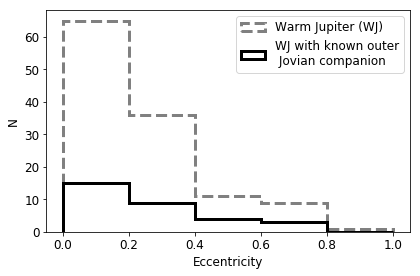

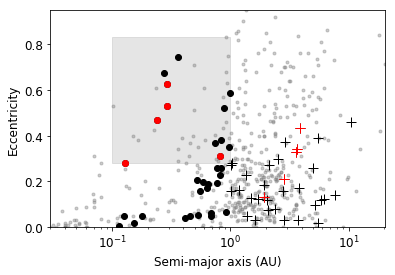

In [5]:
file = 'all_planets.csv'
df = pd.read_csv(file,comment="#")
a = 'pl_orbsmax'
e = 'pl_orbeccen'
method = 'pl_discmethod'
mass = 'pl_bmassj'
host = 'pl_hostname'
N = 'pl_pnum'

c0 = (df[method]=='Radial Velocity')&(df[mass]>=0.25) #jupiters
c1 = (df[method]=='Radial Velocity')&(df[mass]>=0.25)&(df[a]<0.1) #hot jupiters
c2 = (df[method]=='Radial Velocity')&(df[mass]>=0.25)&(df[a]>=0.1)&(df[a]<=1.0) #warm jupiters
c2N = (df[method]=='Radial Velocity')&(df[mass]>=0.25)&(df[a]>=0.1)&(df[a]<=1.0)&(df[N]==2) #warm jupiters
c3 = (df[method]=='Radial Velocity')&(df[mass]>=0.25)&(df[a]>1.0) #cold jupiters
c3N = (df[method]=='Radial Velocity')&(df[mass]>=0.25)&(df[a]>1.0)&(df[N]==2) #cold jupiters


s2 = set(df[c2]['pl_hostname'])
s3 = set(df[c3]['pl_hostname'])
Int = s2.intersection(s3)
df2 = df[df['pl_hostname'].isin(Int)]
df3 = pd.concat([df2[c2],df2[c3]],ignore_index=False).sort_index()

plt.figure()
nbins = 5
bins = np.linspace(0,1,nbins+1)
counts1, bins1, bars1 = plt.hist(df[c2][e],bins=bins,ls='--',label='Warm Jupiter (WJ)',
                                 color='gray',histtype='step',lw=3)
counts2, bins2, bars2 = plt.hist(df2[c2][e],bins=bins,label='WJ with known outer\n Jovian companion',
                                 color='black',histtype='step',lw=3)
plt.ylabel('N')
plt.xlabel('Eccentricity')
plt.legend()
plt.tight_layout()

#plt.savefig('EccenHisto.pdf',bbox_inches='tight')

##########################################################################################################
# plt.figure()
# nbins = 5
# bins = np.linspace(0,1,nbins+1)
# counts1, bins1, bars1 = plt.hist(df[c2N][e],bins=bins,ls='--',label='Warm Jupiter (WJ)',
#                                  color='gray',histtype='step',lw=3)
# counts2, bins2, bars2 = plt.hist(df2[c2N][e],bins=bins,label='WJ with known outer\n Jovian companion',
#                                  color='black',histtype='step',lw=3)
# plt.ylabel('N')
# plt.xlabel('Eccentricity')
# plt.legend()
# #plt.tight_layout()
# plt.rcParams.update({'font.size': 12})
# #plt.savefig('EccenHisto.pdf',bbox_inches='tight')

##########################################################################################################

DC = 'HD 147018','HD 38529','HD 168443','HD 74156','HD 169830','HD 202206'
alpha = 0.4
e0 = 0.28
fig, ax1 = plt.subplots()
ax1.plot(df[c1][a],df[c1][e],'.',color='gray',label='Hot Jupiters',alpha=alpha)
ax1.plot(df[~df[host].isin(df2[host])][c2][a],df[~df[host].isin(df2[host])][c2][e]
         ,'.',color='gray',alpha=alpha,label='Warm Jupiters')
ax1.plot(df[~df[host].isin(df2[host])][c3][a],df[~df[host].isin(df2[host])][c3][e]
         ,'.',color='gray',alpha=alpha,label='Cold Jupiters')
ax1.fill_between([0.1,1.0],[max(df[c2][e]),max(df[c2][e])],[e0,e0], color='gray',alpha=0.2,zorder=0)
ax1.plot(df2[c2][a],df2[c2][e],'o',color='k')
ax1.plot(df2[c3][a],df2[c3][e],'+',ms=10,color='k')

for i in range(len(DC)):
    ax1.plot(df2[df2[host]==DC[i]][c2][a],df2[df2[host]==DC[i]][c2][e],'o',color='r')
    ax1.plot(df2[df2[host]==DC[i]][c3][a],df2[df2[host]==DC[i]][c3][e],'+',ms=10,color='r')

        





# for i,txt in enumerate(df2[c2][df2[c2][e]>=e0]['pl_name']):
#     if df2[c2][df2[c2][e]>=e0][a].iloc[i] < 0.6:
#         #x = df2[c2][df2[c2][e]>e0][a].iloc[i]
#         #y = df2[c2][df2[c2][e]>e0][e].iloc[i]
#         #ax1.annotate(txt,(0.06,y),fontsize=10,color='r')
#         print(txt)
#     else:
#         #x = df2[c2][df2[c2][e]>=e0][a].iloc[i]
#         #y = df2[c2][df2[c2][e]>=e0][e].iloc[i]
#         #ax1.annotate(txt,(x+0.1,y),fontsize=10,color='r')
#         print(txt)



ax1.set_ylabel('Eccentricity')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.set_xscale('log')
plt.margins(x=0,y=0)
#plt.savefig('EccentricitySemimajor.pdf',bbox_inches='tight')


print(counts1,counts2)

In [5]:
df2[c2].shape

/opt/aci/sw/python/3.6.3_anaconda-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(31, 72)

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


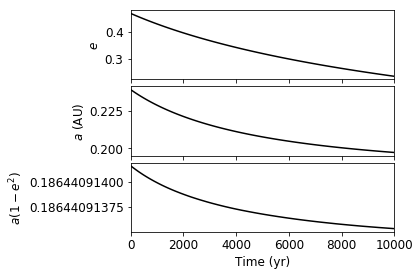

In [29]:
datetag = '20191108T140051'
file = 'simulation_archive/sa'+datetag+'.bin'
sa = rebound.SimulationArchive(file)
e1 = np.zeros(len(sa))
a1 = np.zeros(len(sa))
inc1 = np.zeros(len(sa))

Omega1 = np.zeros(len(sa))

pomega1 = np.zeros(len(sa))



t = np.zeros(len(sa))
for i, sim in enumerate(sa):
    ps = sim.particles
    e1[i] = ps[1].e
    a1[i] = ps[1].a
    inc1[i] = ps[1].inc
    Omega1[i] = ps[1].Omega
    pomega1[i] = ps[1].pomega

    t[i] = sim.t
    
t = t/(2.*np.pi)

#imut = np.degrees(nb.calc_imut(inc1, inc2, Omega1, Omega2))
#deltapomega = np.degrees(nb.calc_deltapomega(pomega1, pomega2))

color='black'
fontsize=12
fig, axarr = plt.subplots(nrows=3,sharex=True)




axarr[0].plot(t,e1,color=color)
axarr[0].set_ylabel(r'$e$', fontsize=fontsize)
axarr[0].margins(x=0)
axarr[1].plot(t, a1,color=color)
axarr[1].set_ylabel(r'$a$ (AU)', fontsize=fontsize)
axarr[1].margins(x=0)
axarr[2].plot(t,a1*(1.-e1*e1),color=color)
axarr[2].ticklabel_format(useOffset=False)
axarr[2].set_ylabel(r'$a(1-e^2)$', fontsize=fontsize)
axarr[2].margins(x=0)
axarr[2].set_xlabel('Time (yr)', fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
#plt.savefig('plots/p'+datetag+'.pdf',bbox_inches='tight')

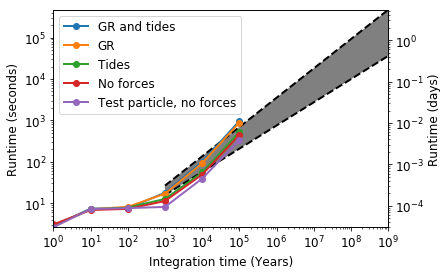

In [37]:
lw = 2
ls = '-'

#file = 'rt20191118T194755.csv'
file = 'rt.eps1e-06.20191125T092113.csv'
df = pd.read_csv('data/'+file)

times = df['times (yr)']
rt0000 = df['rt0000']
rt1100 = df['rt1100']
rt1110 = df['rt1110']
rt1101 = df['rt1101']
rt1111 = df['rt1111']

# plt.plot(times,rt1111,'-o',lw=lw,ls=ls,label='GR and tides')
# plt.plot(times,rt1110,'-o',lw=lw,ls=ls,label='GR')
# plt.plot(times,rt1101,'-o',lw=lw,ls=ls,label='Tides')
# plt.plot(times,rt1100,'-o',lw=lw,ls=ls,label='No forces')
# plt.plot(times,rt0000,'-o',lw=lw,ls=ls,label='Test particle, no forces')
# plt.xlabel('Times (yr)')
# plt.ylabel('Runtime (s)')
# plt.xscale('log')
# plt.yscale('log')
# plt.margins(x=0,y=0)



# plt.legend()



def interp(data_runtimes,data_times,tf=9):
    y = np.log10(data_runtimes[2:])
    x = np.log10(data_times[2:])
    m,b = np.polyfit(x, y, 1)
    t0 = 3
    ts = tf - t0 + 1
    t = np.linspace(t0,tf,ts)
    return m,t,b



m_up,t,b_up = interp(rt1111,times,9)
m_lo,t,b_lo = interp(rt0000,times,9)

y1 = 10.**(m_lo*t+b_lo)
y2 = 10.**(m_up*t+b_up)

x1 = 10**t
x2 = x1




def plot(extrap=False):
    def seconds2days(x):
        """
        Converts seconds to days.
        """
        return x/(60.*60.*24.)#x/fa19
    def convert_ax2_to_days(ax1):
        """
        Update second axis according with first axis.
        """
        y1, y2 = ax1.get_ylim()
        ax2.set_ylim(seconds2days(y1), seconds2days(y2))
        ax2.figure.canvas.draw()

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.callbacks.connect("ylim_changed", convert_ax2_to_days)

    ax2.set_yscale('log')
    ax1.set_yscale('log')
    ax2.set_ylabel('Runtime (days)')
    
    if extrap==True:
        ax1.plot(x2,y2,'--',color='k',lw=lw)
        ax1.plot(x1,y1,'--',color='k',lw=lw)
        ax1.fill_between(x1, y1, y2, where=y2 >= y1, facecolor='gray', interpolate=True)

    ax1.plot(times,rt1111,'-o',lw=lw,ls=ls,label='GR and tides')
    ax1.plot(times,rt1110,'-o',lw=lw,ls=ls,label='GR')
    ax1.plot(times,rt1101,'-o',lw=lw,ls=ls,label='Tides')
    ax1.plot(times,rt1100,'-o',lw=lw,ls=ls,label='No forces')
    ax1.plot(times,rt0000,'-o',lw=lw,ls=ls,label='Test particle, no forces')
    ax1.set_ylabel('Runtime (seconds)')
    ax1.set_xlabel('Integration time (Years)')
    ax1.set_xscale('log')
    ax1.legend(loc='upper left')
    #plt.tight_layout()
    ax1.margins(x=0,y=0)
    #plt.savefig('plots/runtimes.pdf',bbox_inches='tight')

plot(extrap=True)
#plt.savefig('plots/runtimes_forces_extrp.pdf')




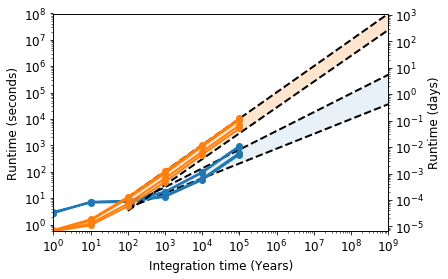

In [38]:
lw = 2
ls = '-'

def interp(data_runtimes,data_times,tf=9):
    y = np.log10(data_runtimes[2:])
    x = np.log10(data_times[2:])
    m,b = np.polyfit(x, y, 1)
    t0 = 2
    ts = tf - t0 + 1
    t = np.linspace(t0,tf,ts)
    return m,t,b




#file = 'rt20191118T194755.csv'
file = 'rt.eps1e-06.20191125T092113.csv'
df = pd.read_csv('data/'+file)
times = df['times (yr)']
rt0000 = df['rt0000']
rt1100 = df['rt1100']
rt1110 = df['rt1110']
rt1101 = df['rt1101']
rt1111 = df['rt1111']
m_up,t,b_up = interp(rt1111,times,9)
m_lo,t,b_lo = interp(rt0000,times,9)
y1 = 10.**(m_lo*t+b_lo)
y2 = 10.**(m_up*t+b_up)
x1 = 10**t
x2 = x1




def seconds2days(x):
    """
    Converts seconds to days.
    """
    return x/(60.*60.*24.)#x/fa19
def convert_ax2_to_days(ax1):
    """
    Update second axis according with first axis.
    """
    y1, y2 = ax1.get_ylim()
    ax2.set_ylim(seconds2days(y1), seconds2days(y2))
    ax2.figure.canvas.draw()

fig, ax1 = plt.subplots()

ax1.set_yscale('log')
ax1.plot(x2,y2,'--',color='k',lw=lw)
ax1.plot(x1,y1,'--',color='k',lw=lw)
ax1.fill_between(x1, y1, y2, where=y2 >= y1, facecolor=blue, interpolate=True,alpha=0.1)

ax1.plot(times,rt1111,'-o',lw=lw,ls=ls,label='GR and tides',color=blue)
ax1.plot(times,rt1110,'-o',lw=lw,ls=ls,label='GR',color=blue)
ax1.plot(times,rt1101,'-o',lw=lw,ls=ls,label='Tides',color=blue)
ax1.plot(times,rt1100,'-o',lw=lw,ls=ls,label='No forces',color=blue)
ax1.set_ylabel('Runtime (seconds)')
ax1.set_xlabel('Integration time (Years)')
ax1.set_xscale('log')
ax1.margins(x=0,y=0)

file = 'rt20191118T194755.csv'
#file = 'rt.eps1e-06.20191125T092113.csv'
df = pd.read_csv('data/'+file)
times = df['times (yr)']
rt0000 = df['rt0000']
rt1100 = df['rt1100']
rt1110 = df['rt1110']
rt1101 = df['rt1101']
rt1111 = df['rt1111']
m_up,t,b_up = interp(rt1111,times,9)
m_lo,t,b_lo = interp(rt0000,times,9)
y1 = 10.**(m_lo*t+b_lo)
y2 = 10.**(m_up*t+b_up)
x1 = 10**t
x2 = x1

ax1.set_yscale('log')
# ax2.set_ylabel('Runtime (days)')

ax2 = ax1.twinx()
ax1.callbacks.connect("ylim_changed", convert_ax2_to_days)
ax2.set_yscale('log')
ax2.set_ylabel('Runtime (days)')


ax1.plot(x2,y2,'--',color='k',lw=lw)
ax1.plot(x1,y1,'--',color='k',lw=lw)
ax1.fill_between(x1, y1, y2, where=y2 >= y1, facecolor=orange, interpolate=True,alpha='0.2')

ax1.plot(times,rt1111,'-o',lw=lw,ls=ls,label='GR and tides',color=orange)
ax1.plot(times,rt1110,'-o',lw=lw,ls=ls,label='GR',color=orange)
ax1.plot(times,rt1101,'-o',lw=lw,ls=ls,label='Tides',color=orange)
ax1.plot(times,rt1100,'-o',lw=lw,ls=ls,label='No forces',color=orange)
ax1.set_ylabel('Runtime (seconds)')
ax1.set_xlabel('Integration time (Years)')
ax1.set_xscale('log')

ax1.margins(x=0,y=0)







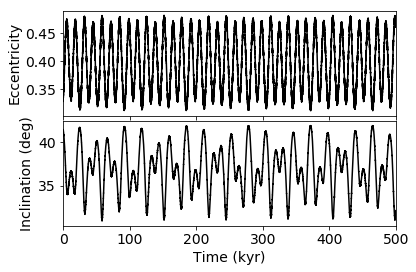

In [36]:

# sim = rebound.Simulation()
# sim.add("Sun")
# # # #sim.add(m=0.,a=3,e=0.4,inc=np.radians(40.),Omega=0.)
# sim.add("1980 LB")
# # sim.add("Vesta")
# sim.add("Jupiter")
# sim.save("ss2.bin")
# sim = rebound.Simulation("ss2.bin")
N = int(1e4)
times = np.linspace(0.,5e5,N)*years
def runsim(sim):
    e1 = np.zeros(N)
    inc1 = np.zeros(N)
    for i,t in enumerate(times):
        ps = sim.particles
        sim.integrate(t)
        e1[i] = ps[1].e
        inc1[i] = ps[1].inc
    return e1,inc1
#e1,inc1 = runsim(sim)
fontsize = 14
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(times/(1e3*years),e1,color='k')
ax[0].set_ylabel('Eccentricity',fontsize=fontsize)
#ax[0].set_ylim(0.,0.2)
ax[1].plot(times/(1e3*years),np.degrees(inc1),color='k')
ax[1].set_ylabel('Inclination (deg)',fontsize=fontsize)
ax[1].set_xlabel('Time (kyr)',fontsize=fontsize)
#ax[1].set_ylim(0.,12)
plt.margins(x=0)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('asteroid_2938Hopi.png',bbox_inches='tight',dpi=400)


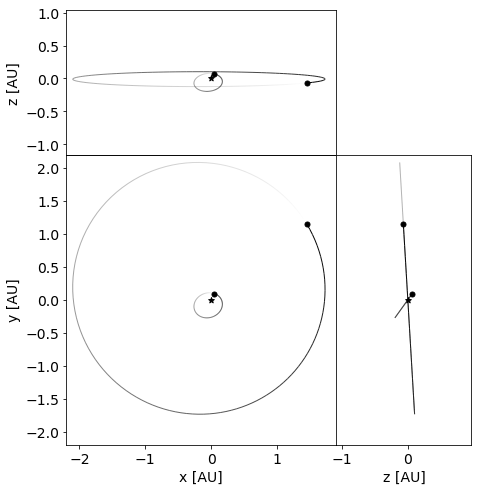

In [45]:
# sim = rebound.Simulation("ss2.bin")
# fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-5.7,5.5],ylim=[-5.5,5.5],unitlabel="[AU]")
#plt.savefig('asteroidOrbit_2938Hopi.png',bbox_inches='tight',dpi=400)

# sim = rebound.Simulation("ss3.bin")
# fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-5.7,5.5],ylim=[-5.7,5.7],unitlabel="[AU]")
#plt.savefig('asteroidOrbit_Vesta.png',bbox_inches='tight',dpi=400)
sim = nb.makesim()
fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-2.2,1.9],ylim=[-2.2,2.2],unitlabel="[AU]")

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


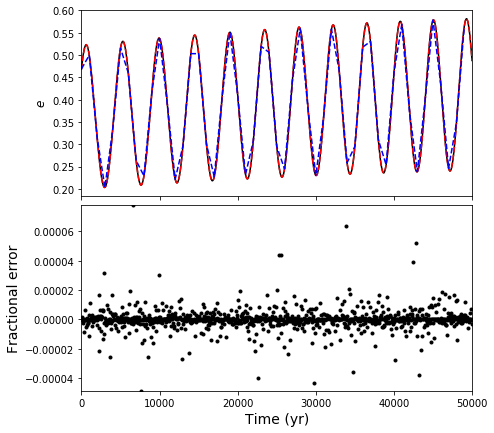

In [9]:

logpath = 'data/datalog_old.csv'
df = pd.read_csv(logpath).astype(str)

file = df[df['datetag']=='20191126T091829']['file'].values[0] #20191129T091555 20191126T091829
times,e1,imut,deltapomega = get_data(file)
color='k'
fontsize=12
times = times/(2.*np.pi)
fig, ax = plt.subplots(nrows=2,sharex=True,figsize=(7,7))
ax[0].plot(times,e1,color=color)
ax[0].set_ylabel(r'$e$', fontsize=fontsize)
ax[0].margins(x=0)

file = df[df['datetag']=='20191126T104149']['file'].values[0]
times,e2,imut,deltapomega = get_data(file)
color='r'
ls = '--'
fontsize=12
times = times/(2.*np.pi)
ax[0].plot(times,e1,ls=ls,color=color)
ax[0].set_ylabel(r'$e$', fontsize=fontsize)
ax[0].margins(x=0)



fs=14
ax[1].plot(times,(e1-e2)/e1,'.',color='black')
ax[1].margins(x=0,y=0)
ax[1].set_ylabel('Fractional error',fontsize=fs)
ax[1].set_xlabel('Time (yr)',fontsize=fs)
plt.subplots_adjust(hspace=0.05)
#plt.savefig('EccenFracError.pdf',bbox_inches='tight')

sapath = 'simulation_archive/'
filename = 'sa20191128T095708.bin'
file = sapath+filename
times,e3,imut,deltapomega = get_data(file)
color='b'
ls = '--'
fontsize=12
times = times/(2.*np.pi)
ax[0].plot(times[times<0.5e5],e3[times<0.5e5],ls=ls,color=color)
ax[0].set_ylabel(r'$e$', fontsize=fontsize)
ax[0].margins(x=0)


array([    0.        ,  1000.00503102,  2000.0093202 ,  3000.00124717,
        4000.00087469,  5000.01111803,  6000.00233652,  7000.00449046,
        8000.00618084,  9000.00627162, 10000.005116  , 11000.00778609,
       12000.01181683, 13000.0022056 , 14000.0010584 , 15000.00777043,
       16000.00090781, 17000.00458649, 18000.01124715, 19000.0095092 ,
       20000.00251279, 21000.00164115, 22000.00731663, 23000.00397173,
       24000.00341355, 25000.007825  , 26000.00954882, 27000.00326711,
       28000.00806284, 29000.00880495, 30000.00785244, 31000.00146124,
       32000.01034563, 33000.00754882, 34000.00089755, 35000.00989021,
       36000.01596406, 37000.00625623, 38000.0002975 , 39000.00906672,
       40000.0151303 , 41000.00126992, 42000.00182319, 43000.01321589,
       44000.004999  , 45000.00360867, 46000.01536788, 47000.01262334,
       48000.00326335, 49000.00303838, 50000.01348003, 51000.00608387,
       52000.0023023 , 53000.00910767, 54000.01483765, 55000.00041646,
      

In [13]:
logpath = 'data/datalog_old.csv'
df = pd.read_csv(logpath).astype(str)
df

date          datetag sim.integrator sim.N ps[0].m  \
0   2019-11-26              nan            nan   nan     nan   
1   2019-11-26  20191126T090247          ias15   3.0   0.927   
2   2019-11-26  20191126T091521          ias15   3.0   0.927   
3   2019-11-26  20191126T091829          ias15   3.0   0.927   
4   2019-11-26  20191126T104149          ias15   3.0   0.927   
5   2019-11-27  20191127T075112          ias15   3.0   0.927   
6   2019-11-27  20191127T075112          ias15   3.0   0.927   
7   2019-11-27  20191127T075112          ias15   3.0   0.927   
8   2019-11-27  20191127T075112          ias15   3.0   0.927   
9   2019-11-27  20191127T075124          ias15   3.0   0.927   
10  2019-11-27  20191127T075124          ias15   3.0   0.927   
11  2019-11-27  20191127T075124          ias15   3.0   0.927   
12  2019-11-27  20191127T075124          ias15   3.0   0.927   
13  2019-11-27  20191127T075210          ias15   3.0   0.927   
14  2019-11-27  20191127T075210          ias15   3.0   0.927   
15  2019-11-27  20191127T075210          ias15   3.0   0.927   
16  2019-11-27  20191127T075211          ias15   3.0   0.927   
17  2019-11-27  20191127T075241          ias15   3.0   0.927   
18  2019-11-27  20191127T080609          ias15   3.0   0.927   
19  2019-11-27  20191127T081034          ias15   3.0   0.927   
20  2019-11-27  20191127T081335          ias15   3.0   0.927   
21  2019-11-27  20191127T083105          ias15   3.0   0.927   

                 ps[1].m             ps[1].a             ps[1].e  \
0                    nan                 nan                 nan   
1   0.002023739776014969  0.2389000000000001  0.4686000000000002   
2   0.002023739776014969  0.2389000000000001  0.4686000000000002   
3   0.002023739776014969  0.2389000000000001  0.4686000000000002   
4   0.002023739776014969  0.2389000000000001  0.4686000000000002   
5                    0.0  1.0000554793954284  0.7967474499060532   
6                    0.0  1.0000554793954284  0.7967474499060532   
7                    0.0  1.0000554793954284  0.7967474499060532   
8                    0.0  1.0000554793954284  0.7967474499060532   
9                    0.0  1.0000554793954284  0.7967474499060532   
10                   0.0  1.0000554793954284  0.7967474499060532   
11                   0.0  1.0000554793954284  0.7967474499060532   
12                   0.0  1.0000554793954284  0.7967474499060532   
13                   0.0  1.0000554793954284  0.7967474499060532   
14                   0.0  1.0000554793954284  0.7967474499060532   
15                   0.0  1.0000554793954284  0.7967474499060532   
16                   0.0  1.0000554793954284  0.7967474499060532   
17  0.002023739776014969  0.2389000000000001  0.4686000000000002   
18  0.002023739776014969  0.2389000000000001  0.4686000000000002   
19  0.002023739776014969  0.2389000000000001  0.4686000000000002   
20  0.002023739776014969  0.2389000000000001  0.4686000000000002   
21  0.002023739776014969  0.2389000000000001  0.4686000000000002   

             ps[1].inc        ps[1].Omega          ...           \
0                  nan                nan          ...            
1   0.6215925379262556                0.0          ...            
2   0.6215925379262556                0.0          ...            
3   0.6215925379262556                0.0          ...            
4   0.6215925379262556                0.0          ...            
5   0.9246091961593988  -1.65111773528712          ...            
6   0.9246091961593988  -1.65111773528712          ...            
7   0.9246091961593988  -1.65111773528712          ...            
8   0.9246091961593988  -1.65111773528712          ...            
9   0.9246091961593988  -1.65111773528712          ...            
10  0.9246091961593988  -1.65111773528712          ...            
11  0.9246091961593988  -1.65111773528712          ...            
12  0.9246091961593988  -1.65111773528712          ...            
13  0.9246091961593988  -1.6511177

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


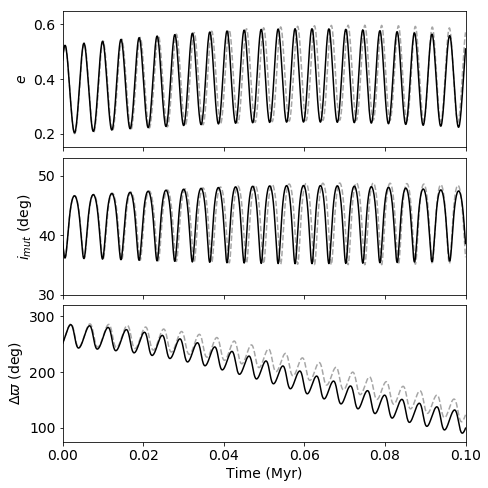

In [30]:
logpath = 'data/datalog_old.csv'
df = pd.read_csv(logpath).astype(str)



file = df[df['datetag']=='20191127T081335']['file'].values[0]
times,e1,imut,deltapomega = get_data(file)
color='black'

times = times/(2.*np.pi)
fig, ax = plt.subplots(nrows=3,sharex=True,figsize=(7,7))
ax[0].plot(times/1e6,e1,color=color)
ax[0].set_ylabel(r'$e$')
ax[0].margins(x=0)
ax[1].plot(times/1e6, imut,color=color)
ax[1].set_ylabel(r'$i_{mut}$ (deg)')
#ax[1].legend(fontsize=24)
ax[1].margins(x=0)
ax[2].plot(times/1e6, deltapomega,color=color)
ax[2].set_ylabel(r'$\Delta\varpi$ (deg)')
#ax[2].legend(fontsize=24)
ax[2].margins(x=0)
ax[2].set_xlabel('Time (Myr)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

file = df[df['datetag']=='20191127T083105']['file'].values[0]
times,e1,imut,deltapomega = get_data(file)
color='gray'
ls = '--'
alpha = 0.7
times = times/(2.*np.pi)
ax[0].plot(times/1e6,e1,ls=ls,color=color,alpha=alpha,zorder=0)
ax[0].set_ylabel(r'$e$')
ax[0].margins(x=0)
ax[0].set_ylim(0.15,0.65)
ax[1].plot(times/1e6, imut,ls=ls,color=color,alpha=alpha,zorder=0)
ax[1].set_ylabel(r'$i_{mut}$ (deg)')
#ax[1].legend(fontsize=24)
ax[1].margins(x=0)
ax[1].set_ylim(30,53)
ax[2].plot(times/1e6, deltapomega,ls=ls,color=color,alpha=alpha,zorder=0)
ax[2].set_ylabel(r'$\Delta\varpi$ (deg)')
#ax[2].legend(fontsize=24)
ax[2].margins(x=0)
ax[2].set_ylim(75,320)
ax[2].set_xlabel('Time (Myr)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.075)
plt.savefig('KozaiGR.pdf',bbox_inches='tight')



/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


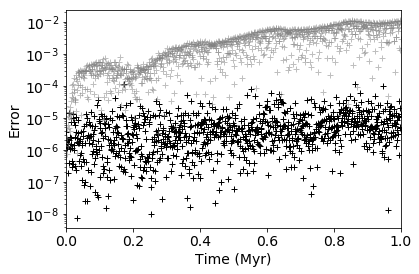

In [17]:
logpath = 'data/datalog.csv'
#df = pd.read_csv(logpath).astype(str)
file = 'simulation_archive/sa20191129T092739.bin'
sa = rebound.SimulationArchive(file)
e9 = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, sim in enumerate(sa):
        ps = sim.particles
        e9[i] = ps[1].e
        times[i] = sim.t
        
file = 'simulation_archive/sa20191129T092250.bin'
sa = rebound.SimulationArchive(file)
e6 = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, sim in enumerate(sa):
        ps = sim.particles
        e6[i] = ps[1].e
        times[i] = sim.t
        
file = 'simulation_archive/sa20191129T091555.bin'
sa = rebound.SimulationArchive(file)
e3 = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, sim in enumerate(sa):
        ps = sim.particles
        e3[i] = ps[1].e
        times[i] = sim.t
        
times = times/(2.*np.pi)/1e6
        
# plt.plot(times/(2.*np.pi),e9,'--')
# plt.plot(times/(2.*np.pi),e6,'.')
# plt.plot(times/(2.*np.pi),e3,'o',alpha=0.3)

plt.plot(times,abs(e6-e9)/e9,'+',c='k')
plt.plot(times,abs(e3-e9)/e9,'+',c='gray',alpha=0.5)

plt.yscale('log')
plt.xlabel('Time (Myr)')
plt.ylabel('Error')
#plt.ylim(1e-9,1e-1)
plt.margins(x=0)

plt.savefig('ErrorAnalysis.pdf',bbox_inches='tight')        

/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulation.py:664: RuntimeWarning: REBOUNDx: Operators that affect particle trajectories with adaptive timesteps can give spurious results. Use sim.ri_ias15.epsilon=0 for fixed timestep with IAS, or use a different integrator.
  warnings.warn(msg[1:], RuntimeWarning)
/storage/home/len56/.local/lib/python3.6/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


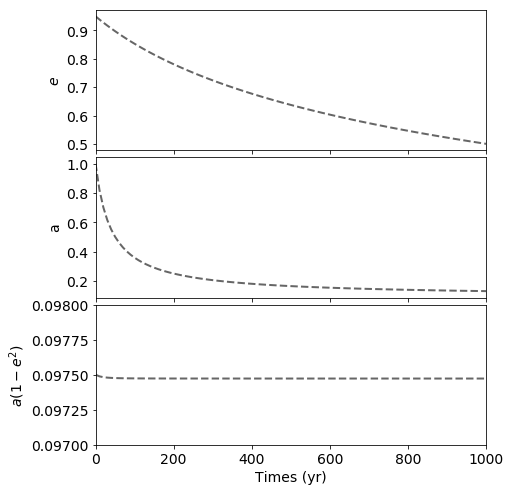

In [3]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=0.,a=1.,e=0.95)
tides = True
GR = False
epsilon = 1e-6
years = 2.*np.pi
tmax = 1000*years
Nout = 100
Q = 1.0e-2
file = nb.runsim(sim,tmax,Nout,GR=GR,tides=tides,Q=Q,epsilon=epsilon)


sa = rebound.SimulationArchive('simulation_archive/'+file)
e = np.zeros(len(sa))
a = np.zeros(len(sa))
times = np.zeros(len(sa))
for i, sim in enumerate(sa):
    ps = sim.particles
    e[i] = ps[1].e
    a[i] = ps[1].a
    times[i] = sim.t
    
times = times/(2.*np.pi)  

fig, ax = plt.subplots(3,1,figsize=(7,8),sharex=True)
c='black'
ls='--'
lw=2
alpha=0.6
ax[0].plot(times,e,c=c,ls=ls,lw=lw,alpha=alpha)
ax[0].margins(x=0)
ax[0].set_ylabel(r'$e$')
ax[1].plot(times,a,c=c,ls=ls,lw=lw,alpha=alpha)
ax[1].margins(x=0)
ax[1].set_ylabel(r'a')
ax[2].plot(times,a*(1.-e*e),c=c,ls=ls,lw=lw,alpha=alpha)
ax[2].set_ylim(0.097,0.098)
ax[2].margins(x=0)
ax[2].set_ylabel(r'$a(1-e^2)$')
ax[2].set_xlabel('Times (yr)')
plt.subplots_adjust(hspace=0.05)
#plt.savefig('plots/CustomMigration.pdf',bbox_inches='tight')
    

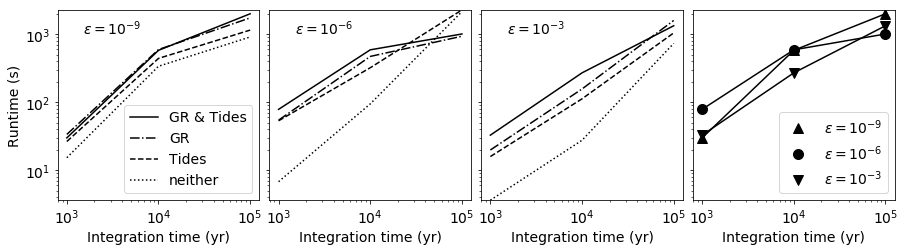

In [6]:
df = pd.read_csv(logpath).astype(str)[cols]
eps3G = df[(df['epsilon']=='0.001')&(df['GR']=='True')&(df['tides']=='False')]
eps3T = df[(df['epsilon']=='0.001')&(df['GR']=='False')&(df['tides']=='True')]
eps3n = df[(df['epsilon']=='0.001')&(df['GR']=='False')&(df['tides']=='False')]
eps3b = df[(df['epsilon']=='0.001')&(df['GR']=='True')&(df['tides']=='True')]

eps6n = df[(df['epsilon']=='1e-06')&(df['GR']=='False')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps6T = df[(df['epsilon']=='1e-06')&(df['GR']=='False')&(df['tides']=='True')]
eps6G = df[(df['epsilon']=='1e-06')&(df['GR']=='True')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps6b = df[(df['epsilon']=='1e-06')&(df['GR']=='True')&(df['tides']=='True')&(df['notes']=='benchmark')]

eps9n = df[(df['epsilon']=='1e-09')&(df['GR']=='False')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps9T = df[(df['epsilon']=='1e-09')&(df['GR']=='False')&(df['tides']=='True')]
eps9G = df[(df['epsilon']=='1e-09')&(df['GR']=='True')&(df['tides']=='False')&(df['notes']=='benchmark')]
eps9b = df[(df['epsilon']=='1e-09')&(df['GR']=='True')&(df['tides']=='True')&(df['notes']=='benchmark')]

fig,ax = plt.subplots(1,4,figsize=(15,3.5),sharey=True)
ms = 10

ax[2].plot(eps3G['tmax'].astype(float),eps3G['runtime'].astype(float),'-.',c='k',ms=ms,label='GR')
ax[2].plot(eps3T['tmax'].astype(float),eps3T['runtime'].astype(float),'--',c='k',ms=ms,label='Tides')
ax[2].plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),'-',c='k',ms=ms,label='GR & Tides')
ax[2].plot(eps3n['tmax'].astype(float),eps3n['runtime'].astype(float),':',c='k',ms=ms,label='neither')
ax[2].annotate('$\epsilon = 10^{-3}$',(1500,1000))


ax[1].plot(eps6G['tmax'].astype(float),eps6G['runtime'].astype(float),'-.',c='k',ms=ms,label='GR')
ax[1].plot(eps6n['tmax'].astype(float),eps6n['runtime'].astype(float),':',c='k',ms=ms,label='neither')
ax[1].plot(eps6T['tmax'].astype(float),eps6T['runtime'].astype(float),'--',c='k',ms=ms,label='Tides')
ax[1].plot(eps6b['tmax'].astype(float),eps6b['runtime'].astype(float),'-',c='k',ms=ms,label='GR & Tides')
ax[1].annotate('$\epsilon = 10^{-6}$',(1500,1000))


ax[0].plot(eps9b['tmax'].astype(float),eps9b['runtime'].astype(float),'-',c='k',ms=ms,label='GR & Tides')
ax[0].plot(eps9G['tmax'].astype(float),eps9G['runtime'].astype(float),'-.',c='k',ms=ms,label='GR')
ax[0].plot(eps9T['tmax'].astype(float),eps9T['runtime'].astype(float),'--',c='k',ms=ms,label='Tides')
ax[0].plot(eps9n['tmax'].astype(float),eps9n['runtime'].astype(float),':',c='k',ms=ms,label='neither')
ax[0].legend(loc='lower right')
ax[0].annotate('$\epsilon = 10^{-9}$',(1500,1000))

ax[3].plot(eps9b['tmax'].astype(float),eps9b['runtime'].astype(float),'^',c='k',ms=ms,label='$\epsilon = 10^{-9}$')
ax[3].plot(eps6b['tmax'].astype(float),eps6b['runtime'].astype(float),'o',c='k',ms=ms,label='$\epsilon = 10^{-6}$')
ax[3].plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),'v',c='k',ms=ms,label='$\epsilon = 10^{-3}$')
ax[3].legend(loc='lower right')
ax[3].plot(eps9b['tmax'].astype(float),eps9b['runtime'].astype(float),'-',c='k',ms=ms)
ax[3].plot(eps6b['tmax'].astype(float),eps6b['runtime'].astype(float),'-',c='k',ms=ms)
ax[3].plot(eps3b['tmax'].astype(float),eps3b['runtime'].astype(float),'-',c='k',ms=ms)



ax[0].set_ylabel('Runtime (s)')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[0].set_xlabel('Integration time (yr)')
ax[1].set_xlabel('Integration time (yr)')
ax[2].set_xlabel('Integration time (yr)')
ax[3].set_xlabel('Integration time (yr)')

plt.margins(y=0)
plt.subplots_adjust(wspace=0.05)
#plt.savefig('plots/RuntimeAnalysis.pdf',bbox_inches='tight')

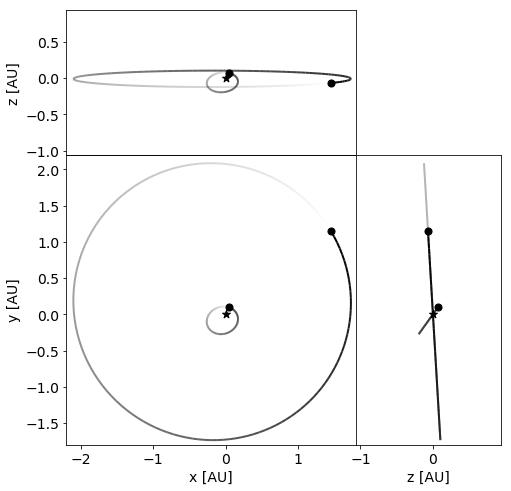

In [50]:
#sim = nb.makesim_past()
sim = nb.makesim()
fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-2.2,1.8],ylim=[-1.8,2.2],lw=2,unitlabel="[AU]")
#plt.savefig('plots/OrbitHD147018b.pdf',bbox_inches='tight')

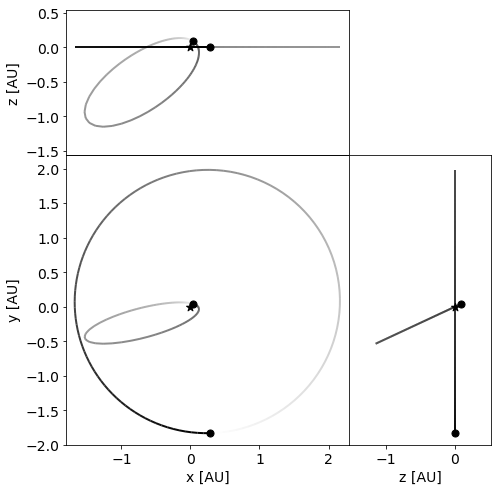

In [58]:
sim = nb.makesim_past()
#sim = nb.makesim()
fig = rebound.OrbitPlot(sim,slices=0.5,xlim=[-1.8,2.3],ylim=[-2.0,2.2],lw=2,unitlabel="[AU]")
#plt.savefig('plots/OrbitHD147018b_past.pdf',bbox_inches='tight')